## 🐬 **Created by** : Lucrece (Jahyun) Shin
## 🐬 **Latest Edit** : January 28, 2022
## 🐬 **Associated Blog Post** : 

# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time, os, pickle
from PIL import Image, ImageFile
import pandas as pd
import seaborn as sns
from collections import OrderedDict, deque
from sklearn.metrics import confusion_matrix, classification_report
import cv2 
from google.colab.patches import cv2_imshow
from glob import glob

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

ImageFile.LOAD_TRUNCATED_IMAGES = True
use_cuda = torch.cuda.is_available()

# Import your Google drive if necessary

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Import your data folders from your Google Drive

In [ ]:
# run this cell once

# 3 classes : gun, knife, benign
!cp 'gdrive/My Drive/Xray-3cls_small.zip' . 
!unzip -qq Xray-3cls_small.zip
!rm Xray-3cls_small.zip 
# remove Kitchen knife & Cutter knife images
!rm Xray-3cls_small/knife/Kitchen*
!rm Xray-3cls_small/knife/Cutter*

# Define ViT model from downloadable pre-trained checkpoints

In [ ]:
!pip install ml_collections
!git clone https://github.com/jeonsworld/ViT-pytorch.git
!mv ViT-pytorch/* .

     |████████████████████████████████| 77 kB 4.6 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=b420a6cc3bebfeffe1f619d525527312301318f4c2b435aff63f1677bf416c41
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collections
Cloning into 'ViT-pytorch'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 170 (delta 32), reused 27 (delta 27), pack-reused 130
Receiving objects: 100% (170/170), 21.31 MiB | 29.05 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [ ]:
from urllib.request import urlretrieve
from models.modeling import VisionTransformer, CONFIGS

os.makedirs("model_checkpoints", exist_ok=True)
if not os.path.isfile("model_checkpoints/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", 
                "model_checkpoints/ViT-B_16-224.npz")

config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True) 
model.load_from(np.load("model_checkpoints/ViT-B_16-224.npz"))

# Define Encoder & Classifier

In [ ]:
encoder = nn.Sequential(*[model.transformer.embeddings, model.transformer.encoder])
ViT_embed_dim = 768  # final embedding dimension for ViT-B
n_classes = 3        # number of classes for my dataset
classifier = nn.Linear(ViT_embed_dim, n_classes)

## load pre-trained / fine-tuned model

In [ ]:
!cp gdrive/MyDrive/encoder_1.pt .
!cp gdrive/MyDrive/classifier_1.pt .
encoder.load_state_dict(torch.load("encoder_1.pt"))
classifier.load_state_dict(torch.load("classifier_1.pt"))

<All keys matched successfully>

# Define ViT_IterativeErasing() Class

In [ ]:
class ViT_IterativeErasing():
  def __init__(self,
               encoder,           # trained ViT encoder
               classifier,        # trained classifier
               detect_th=0.1, 
               reconsider_th=0.001,
               max_iter=5,        # maximum number of iterations to erase images
               img_transform=None # PyTorch transform to apply to raw images (optional)
               ):

    self.encoder = encoder
    self.encoder.cuda().eval()
    self.classifier = classifier
    self.classifier.cuda().eval()

    self.detect_th = detect_th
    self.reconsider_th = reconsider_th
    print("detect threshold :", self.detect_th)
    print("reconsider threshold :", self.reconsider_th)
    self.max_iter = max_iter
    if img_transform:
      self.transform = img_transform
    else:
      self.transform = transforms.ToTensor()

  
  def extract_CLS_final_layer_att_mat(self, 
                                      att_mat
                                      ):
    ''' Extract [CLS] token's final layer attention weights 
        w.r.t. input image tokens '''

    ##  Stack 12 layers  
    att_mat = torch.stack(att_mat).squeeze(1) # [12 (layers), 12 (heads), 197, 197]
    ##  Average across 12 heads  
    att_mat = torch.mean(att_mat, dim=1)      # [12, 197, 197]

    ##  Create an identity matrix  
    residual_att = torch.eye(att_mat.size(1)).cuda() # [197, 197]
    ##  To account for residual connection within each self-attention layer,  
    ##  add identity matrix to attention matrix  
    aug_att_mat = att_mat + residual_att      # [12, 197, 197]
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1) # normalize
    ##  Compute attention grid size (each attention map is a square)  
    grid_size = int(np.sqrt(aug_att_mat.size(-1)-1))  

    ##  To compute Layer i features' attention w.r.t. input image tokens,   
    ##  recursively multiply all previous layers' attention matrices  
    joint_attentions = torch.zeros(aug_att_mat.size()).cuda()   # [12, 197, 197]
    joint_attentions[0] = aug_att_mat[0]
    for n in range(1, aug_att_mat.size(0)):
      joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    ##  Extract the LAST self-attention layer's attention map  
    att_last_layer = joint_attentions[-1]  # [197, 197]
    ##  Extract [CLS] token's attention map = first of 197 attention maps  
    att_CLS = att_last_layer[0, 1:]        # [197]
    ##  Resize the attention map into square dimension
    att_CLS = att_CLS.reshape(grid_size, grid_size).cpu().detach().numpy() # [14, 14]
    att_CLS = att_CLS / att_CLS.max()  # normalize

    return att_CLS


  def mask_image(self,
                 img_path,
                 plot=True,
                 labels=None,
                 topN=3, 
                ):
    ''' Mask image with [CLS] token's final layer attention map '''

    ############################################################################
    ############### 1. Forward the test Image through trained ViT ##############
    ############################################################################
    im = Image.open(img_path).convert('RGB') 
    x = self.transform(im).cuda().unsqueeze(0) 

    with torch.no_grad():
      features, att_mat = self.encoder(x)       # att_mat: a list of 12 [1, 12, 197, 197] tensors
    logits = self.classifier(features[:, 0, :]) # use first [cls] token to classify
    probs = nn.Sigmoid()(logits).squeeze(0) 


    ############################################################################
    ### 2. Extract [CLS] token's final layer att weights wrt input img tokens ##
    ############################################################################
    att_CLS = self.extract_CLS_final_layer_att_mat(att_mat)
    

    ############################################################################
    ################### 3. Mask the image with attention mask ##################
    ############################################################################
    ## Resize [CLS] token's attention map (14x14) to Test Image Size
    mask = cv2.resize(att_CLS, (np.array(im).shape[0], np.array(im).shape[1]))
    if (mask.shape[0]==np.array(im).shape[1]) and (mask.shape[1]==np.array(im).shape[0]):
      # if dimensions are reversed, reverse them back
      mask = cv2.resize(mask, (np.array(im).shape[1], np.array(im).shape[0]))   
    
    im_ = np.array(im).transpose(2,0,1) # transpose image to be compatible with matplotlib
    ## Multiply the mask to each channel of the image
    im_masked_new = np.array([im_channel * mask for im_channel in im_])
    im_masked_new = im_masked_new/im_masked_new.max()  # normalize

    # Print topN highest class predictions
    if labels:
      top_cls_idxs = torch.argsort(probs, dim=-1, descending=True)
      labels = [l+"\n" for l in labels] 
      if plot:
        for idx in top_cls_idxs[:topN]:
          print(f'{probs[idx.item()]:.5f} : {labels[idx.item()]}', end='')


    ############################################################################
    ##################### 4. Save and plot the masked image ####################
    ############################################################################
    if not os.path.exists("mask_images"): # if folder to save masked images don't exist, create one
      os.makedirs("mask_images")
    fname = "mask_images/" + img_path.split("/")[-1] + "_masked.jpg"
    
    plt.imsave(fname, im_masked_new.transpose(1,2,0))  # save the masked image

    if plot:
      plt.imshow(im_masked_new.transpose(1,2,0))  # plot the masked image
      plt.title("Masked Image:")

      mask = cv2.normalize(mask[..., np.newaxis], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) # [im_H, im_W]
      mask_heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET) # [im_H, im_W, 3]
      im_temp = cv2.imread(img_path, 1) 
      # overlay test image & attention heatmap
      overlaid = cv2.addWeighted(im_temp, 0.5, mask_heatmap, 0.5, 0)
      fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 16))
      ax1.set_title('Original')
      ax2.set_title('Heatmap')
      ax3.set_title('Attention Map')
      _ = ax1.imshow(im)
      _ = ax2.imshow(mask_heatmap[:,:,::-1])
      _ = ax3.imshow(overlaid[:,:,::-1])
    
    return joint_attentions, grid_size, im_masked_new, probs, fname


  def detect_class(self,
                   img_path,  # path to image (single image)
                   ):
    ''' Iteratively mask (erase) image until a class is detected
        or maximum number of iterations is reached '''

    fname = img_path
    iter = 0
    while (iter < self.max_iter): 
      ## Mask image ##
      _, _, im_masked, probs, fname = self.mask_image(fname, plot=False)

      ##########################################################################
      ## Option 1- Not worth reconsidering? Exit the loop & return none-class ##
      ##########################################################################
      reconsider = [int(p >= self.reconsider_th) for p in probs[1:]] 
      if im_masked is None or sum(reconsider)==0:
        # for my dataset, class 1 is  "none" class, so I'm returning class index 0.
        return 0 

      ##########################################################################
      ## Option 2- A class detected? Exit the loop & return the detected class #
      ##########################################################################
      detected = [int(p >= self.detect_th) for p in probs[1:]] 
      if sum(detected) == 1:  # one class detected
        return detected.index(1) + 1
      elif sum(detected) > 1: # multiple classes detected
        return [i+1 for i, d in enumerate(detected) if d==1]
      
      ##########################################################################
      ####### Option 3- If neither, mask (erase) the image to test again #######
      ##########################################################################
      iter += 1

    return 0  
  

  def show_confusion_matrix(self,
                            img_dir, # must contain folders named after each class & containing corresponding class images
                            label_dict # dict with keys as class name strings & values as corresponding class index (starting from 0) e.g. {"cat":0, "dog":1}
                            ):
    ''' Classify all images in `img_dir` and print the resulting confusion  
        matrix of new predictions using iterative erasing '''

    cm = np.zeros((3,3)) # intializae confusion matrix
    for cls in os.listdir(img_dir):
      for img_path in os.listdir(os.path.join(img_dir, cls)):
        pred = self.detect_class(os.path.join(img_dir, cls, img_path))
        cm[label_dict[cls], pred] += 1
      print(cls + " done.")

    return cm

## Define a class instance

In [ ]:
iterative_eraser = ViT_DetectByIterativeErasing(encoder, classifier, img_transform=transform['valid'])

detect threshold : 0.1
reconsider threshold : 0.001


# Plot attention heatmap and masked image

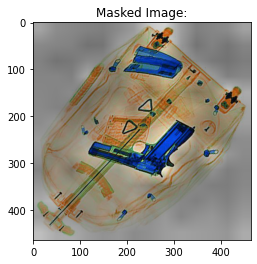

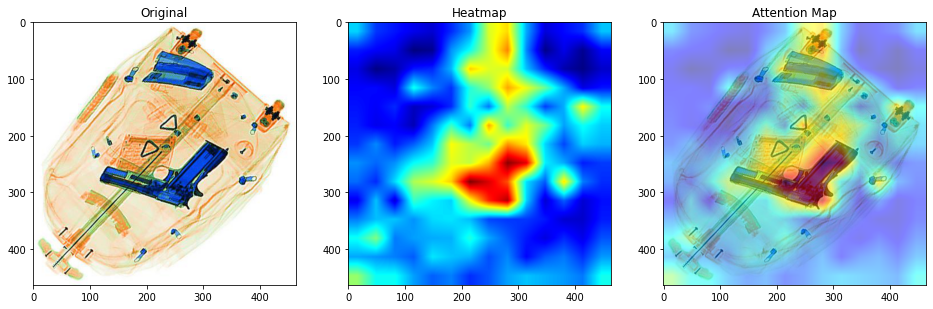

In [ ]:
joint_attentions, grid_size, im_masked_new, probs, fname = iterative_eraser.mask_image(img_path="Xray-3cls_small/gun/0002.jpg")

# Show confusion matrix for all images in `img_dir` folder

`img_dir` folder must contain sub-folders named after each class and each  containing image of the corresponding class.

In [ ]:
img_dir = "Xray-3cls_small" # insert your img_dir here. It must contain sub-folders named after each class and each containing image of the corresponding class.
iterative_eraser.show_confusion_matrix(img_dir=img_dir, label_dict = {"benign":0, "gun":1, "knife":2})

knife done.
gun done.
benign_inch done.


array([[277.,   6.,  17.],
       [ 30.,  85.,   4.],
       [  6.,   3.,  25.]])